In [1]:
import optuna
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import ARIMA
from utilsforecast.evaluation import evaluate

import warnings
import logging

warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("optuna").setLevel(logging.WARNING)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Definir las métricas
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Evaluación de métricas
def evaluate(cv_df, metrics):
    results = {}
    for metric in metrics:
        y_true = cv_df['y'].values
        y_pred = cv_df['ARIMA'].values
        results[metric.__name__] = metric(y_true, y_pred)
    return results

In [3]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1d')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [4]:
horizon = 180

In [5]:
# Definir función para optimización por ticker
def optimize_for_ticker(ticker):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]

    print(f"Number of observations for {ticker}: {len(Y_df_ticker)}")

    if Y_df_ticker['y'].isnull().any():
        print(f"NaN values found in {ticker}.")
        return None, None  # Retorna None para ambos si hay NaN

    # Diccionario para almacenar las métricas
    metrics_dict = {}

    # Definir función objetivo para Optuna
    def objective(trial):
        order = (trial.suggest_int('p', 0, 2), 
                 trial.suggest_int('d', 0, 1), 
                 trial.suggest_int('q', 0, 2))
        seasonal_order = (trial.suggest_int('P', 0, 1), 
                          trial.suggest_int('D', 0, 1), 
                          trial.suggest_int('Q', 0, 1))
        season_length = trial.suggest_int('season_length', 1, min(7, len(Y_df_ticker)))

        # Instanciar el modelo ARIMA
        model = ARIMA(order=order, seasonal_order=seasonal_order, season_length=season_length)

        sf = StatsForecast(df=Y_df_ticker, models=[model], freq='D', n_jobs=-1)

        # Validación cruzada
        cv_df = sf.cross_validation(df=Y_df_ticker, h=horizon, step_size=horizon, n_windows=5).reset_index()

        # Evaluación de las predicciones
        evaluation_results = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'], metrics=[smape, mape, mse, mae, rmse])

        # Guardar las métricas para el análisis posterior
        metrics_dict[trial.number] = {
            'smape': evaluation_results['smape'],
            'mape': evaluation_results['mape'],
            'mse': evaluation_results['mse'],
            'mae': evaluation_results['mae'],
            'rmse': evaluation_results['rmse']
        }

        return evaluation_results['smape']

    # Optimización con Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=25)

    best_params = study.best_params
    best_trial = study.best_trial.number

    print(f"Best hyperparameters for {ticker}: {best_params}")
    print(f"Best SMAPE for {ticker}: {study.best_value}")
    print(f"Metrics for the best trial ({best_trial}): {metrics_dict[best_trial]}")

    return best_params, metrics_dict[best_trial]

In [6]:
# Crear modelo y predecir
def create_model_and_predict(ticker, best_params):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]

    # Crear modelo final con los mejores parámetros
    final_model = ARIMA(
        order=(best_params['p'], best_params['d'], best_params['q']),
        seasonal_order=(best_params['P'], best_params['D'], best_params['Q']),
        season_length=best_params['season_length']
    )

    sf_final = StatsForecast(df=Y_df_ticker, models=[final_model], freq='D', n_jobs=-1)

    prediction_length = len(Y_df_ticker) - horizon
    Y_df_real = Y_df_ticker[:prediction_length]

    sf_final.fit(Y_df_real)
    forecast = sf_final.forecast(h=horizon)

    print(f"Predictions for {ticker}:")
    print(forecast)

    return forecast

In [11]:
def plot_predictions(ticker, forecast):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]
    
    # Graficar
    plt.figure(figsize=(12, 6))

    # Datos reales (históricos)
    real_series = Y_df_ticker[['ds', 'y']]  
    plt.plot(real_series['ds'], real_series['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

    # Predicciones
    forecast_series = forecast[['ds', 'ARIMA']]
    plt.plot(forecast_series['ds'], forecast_series['ARIMA'], label='Prediction', marker='x', color='orange', linestyle='--', linewidth=2)

    # Ampliar la zona de predicción
    plt.axvspan(forecast_series['ds'].min(), forecast_series['ds'].max(), color='orange', alpha=0.1, label='Prediction Range')

    # Configurar el gráfico
    plt.title(f'Predictions vs Actual Data for {ticker}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    
    # Focalizar en la zona de predicción: mostrar solo las fechas de predicción
    min_prediction_date = forecast_series['ds'].min() - pd.DateOffset(months=1)  
    max_prediction_date = forecast_series['ds'].max() + pd.DateOffset(months=1) 
    plt.xlim([min_prediction_date, max_prediction_date])

    # Mostrar una cuadrícula
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

In [8]:
# Optimización para cada ticker
best_params_dict = {}
for ticker in tickers:
    print(f"\nOptimizando para {ticker}...")
    best_params, best_metrics = optimize_for_ticker(ticker)
    if best_params is not None:
        best_params_dict[ticker] = best_params


Optimizando para AAPL...
Number of observations for AAPL: 6230
Best hyperparameters for AAPL: {'p': 0, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 1, 'season_length': 3}
Best SMAPE for AAPL: 10.123316198587418
Metrics for the best trial (16): {'smape': 10.123316198587418, 'mape': 10.577816516160965, 'mse': 414.77383, 'mae': 16.69934, 'rmse': 20.365997}

Optimizando para MSFT...
Number of observations for MSFT: 6230
Best hyperparameters for MSFT: {'p': 2, 'd': 1, 'q': 2, 'P': 0, 'D': 0, 'Q': 1, 'season_length': 2}
Best SMAPE for MSFT: 12.303631752729416
Metrics for the best trial (24): {'smape': 12.303631752729416, 'mape': 12.238311767578125, 'mse': 1903.6125, 'mae': 36.45644, 'rmse': 43.63041}

Optimizando para GOOGL...
Number of observations for GOOGL: 5068
Best hyperparameters for GOOGL: {'p': 1, 'd': 0, 'q': 2, 'P': 1, 'D': 0, 'Q': 0, 'season_length': 2}
Best SMAPE for GOOGL: 17.00359135866165
Metrics for the best trial (23): {'smape': 17.00359135866165, 'mape': 16.581934690475464, 'mse':

[W 2024-10-07 20:30:17,514] Trial 2 failed with parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 1, 'season_length': 6} because of the following error: The value nan is not acceptable.
[W 2024-10-07 20:30:17,515] Trial 2 failed with value nan.


Best hyperparameters for AMZN: {'p': 0, 'd': 0, 'q': 2, 'P': 1, 'D': 1, 'Q': 1, 'season_length': 6}
Best SMAPE for AMZN: 19.78144943714142
Metrics for the best trial (17): {'smape': 19.78144943714142, 'mape': 20.57287245988846, 'mse': 981.16125, 'mae': 27.169765, 'rmse': 31.323494}

Optimizando para NVDA...
Number of observations for NVDA: 6230


[W 2024-10-07 20:36:30,559] Trial 17 failed with parameters: {'p': 2, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 0, 'season_length': 2} because of the following error: The value nan is not acceptable.
[W 2024-10-07 20:36:30,559] Trial 17 failed with value nan.
[W 2024-10-07 20:36:32,604] Trial 18 failed with parameters: {'p': 2, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 0, 'season_length': 2} because of the following error: The value nan is not acceptable.
[W 2024-10-07 20:36:32,606] Trial 18 failed with value nan.
[W 2024-10-07 20:36:34,788] Trial 19 failed with parameters: {'p': 2, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 0, 'season_length': 2} because of the following error: The value nan is not acceptable.
[W 2024-10-07 20:36:34,789] Trial 19 failed with value nan.
[W 2024-10-07 20:36:36,781] Trial 20 failed with parameters: {'p': 2, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 0, 'season_length': 2} because of the following error: The value nan is not acceptable.
[W 2024-10-07 20:36:36,783] Trial 20 fai

Best hyperparameters for NVDA: {'p': 1, 'd': 0, 'q': 2, 'P': 0, 'D': 1, 'Q': 0, 'season_length': 4}
Best SMAPE for NVDA: 37.4860405921936
Metrics for the best trial (6): {'smape': 37.4860405921936, 'mape': 34.94572341442108, 'mse': 522.8634, 'mae': 15.379473, 'rmse': 22.866207}

Optimizando para META...
Number of observations for META: 3116


[W 2024-10-07 20:37:19,543] Trial 20 failed with parameters: {'p': 1, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 0, 'season_length': 5} because of the following error: The value nan is not acceptable.
[W 2024-10-07 20:37:19,544] Trial 20 failed with value nan.


Best hyperparameters for META: {'p': 2, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 0, 'season_length': 2}
Best SMAPE for META: 21.296539902687073
Metrics for the best trial (13): {'smape': 21.296539902687073, 'mape': 23.698656260967255, 'mse': 5189.326, 'mae': 55.49039, 'rmse': 72.03698}

Optimizando para IBM...
Number of observations for IBM: 6230
Best hyperparameters for IBM: {'p': 2, 'd': 0, 'q': 1, 'P': 1, 'D': 1, 'Q': 0, 'season_length': 4}
Best SMAPE for IBM: 10.681791603565216
Metrics for the best trial (8): {'smape': 10.681791603565216, 'mape': 9.948427230119705, 'mse': 318.0481, 'mae': 14.059727, 'rmse': 17.833902}

Optimizando para BTC-USD...
Number of observations for BTC-USD: 3674
Best hyperparameters for BTC-USD: {'p': 2, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 0, 'season_length': 5}
Best SMAPE for BTC-USD: 27.42326557636261
Metrics for the best trial (22): {'smape': 27.42326557636261, 'mape': 27.886399626731873, 'mse': 190339000.0, 'mae': 9489.151, 'rmse': 13796.341}


In [9]:
# Crear y predecir
import time
forecasts_dict = {}

for ticker in tickers:
    if ticker in best_params_dict:
        print(f"\nCreando el modelo y realizando predicciones para {ticker}...")

        start_time = time.time()
        forecast = create_model_and_predict(ticker, best_params_dict[ticker])
        end_time = time.time()

        print(f"Tiempo de predicción para {ticker}: {end_time - start_time:.2f} segundos")
        forecasts_dict[ticker] = forecast


Creando el modelo y realizando predicciones para AAPL...
Predictions for AAPL:
                  ds       ARIMA
unique_id                       
AAPL      2024-01-20  190.832336
AAPL      2024-01-21  190.732880
AAPL      2024-01-22  190.816910
AAPL      2024-01-23  190.899933
AAPL      2024-01-24  190.895920
...              ...         ...
AAPL      2024-07-13  202.546570
AAPL      2024-07-14  202.674789
AAPL      2024-07-15  202.756470
AAPL      2024-07-16  202.750961
AAPL      2024-07-17  202.879181

[180 rows x 2 columns]
Tiempo de predicción para AAPL: 1.67 segundos

Creando el modelo y realizando predicciones para MSFT...
Predictions for MSFT:
                  ds       ARIMA
unique_id                       
MSFT      2024-01-20  395.827698
MSFT      2024-01-21  395.658966
MSFT      2024-01-22  395.584961
MSFT      2024-01-23  395.575592
MSFT      2024-01-24  395.563507
...              ...         ...
MSFT      2024-07-13  395.558502
MSFT      2024-07-14  395.558502
MSFT      2


Graficando las predicciones para AAPL...


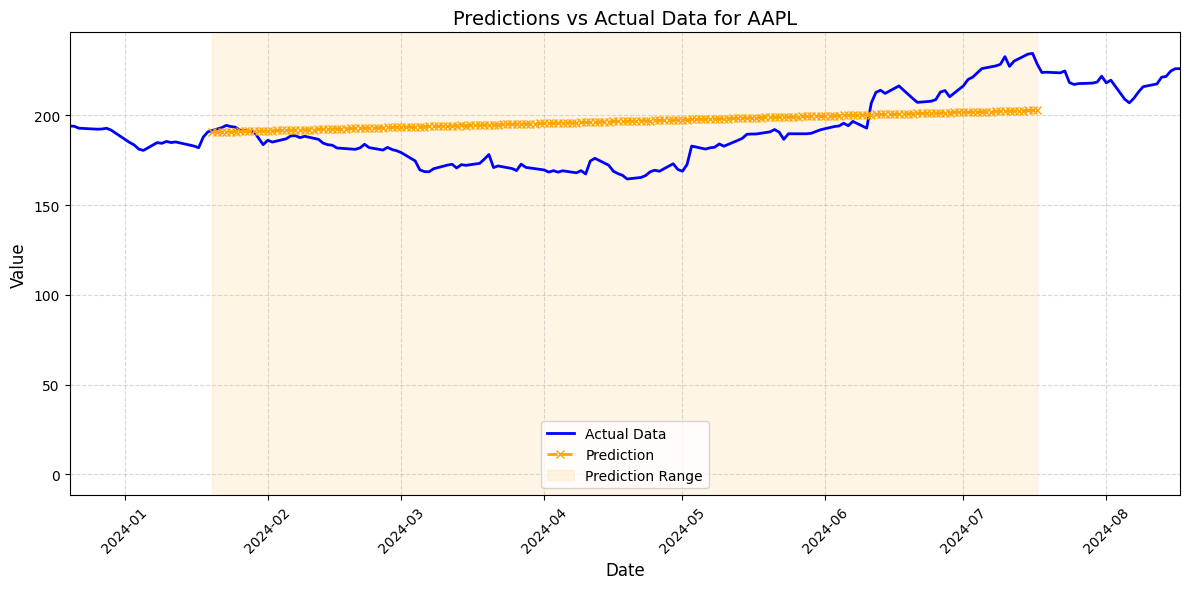


Graficando las predicciones para MSFT...


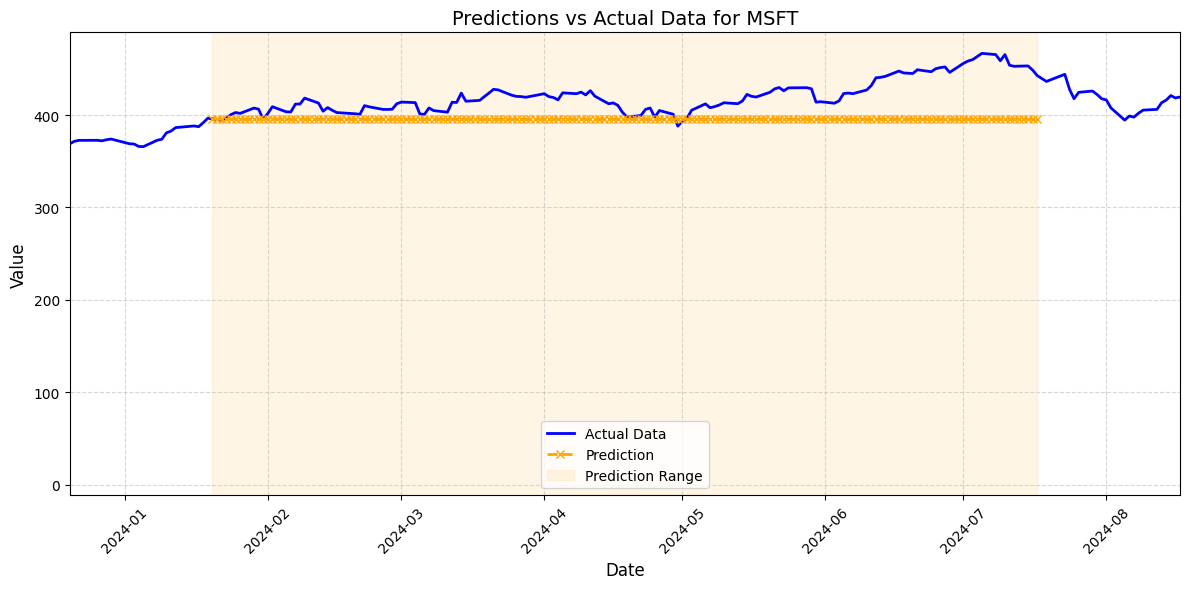


Graficando las predicciones para GOOGL...


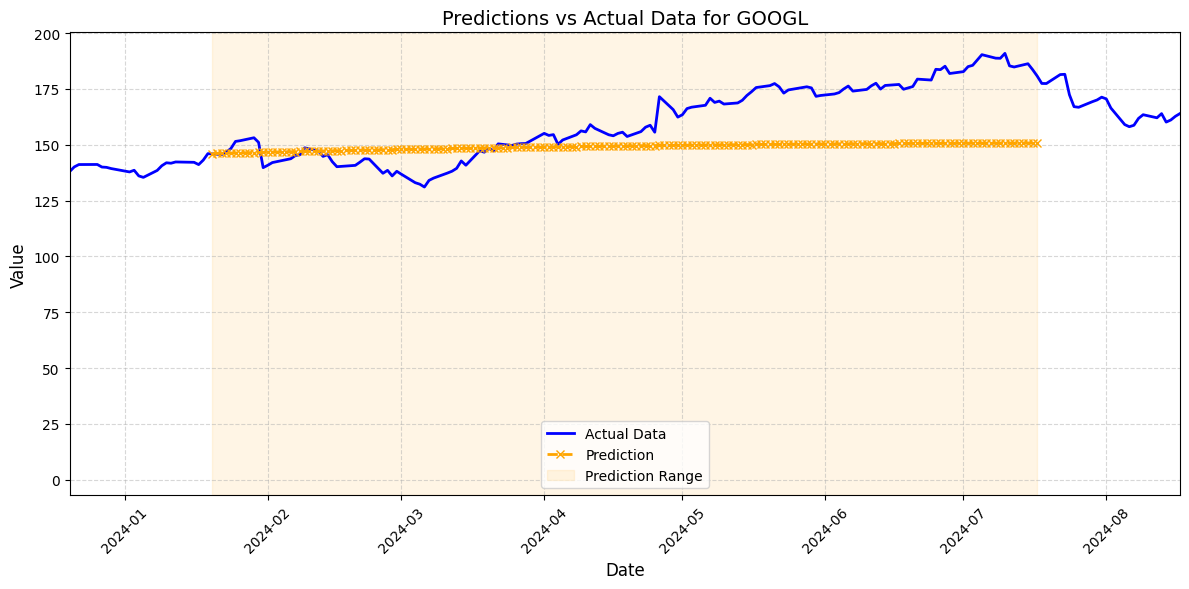


Graficando las predicciones para AMZN...


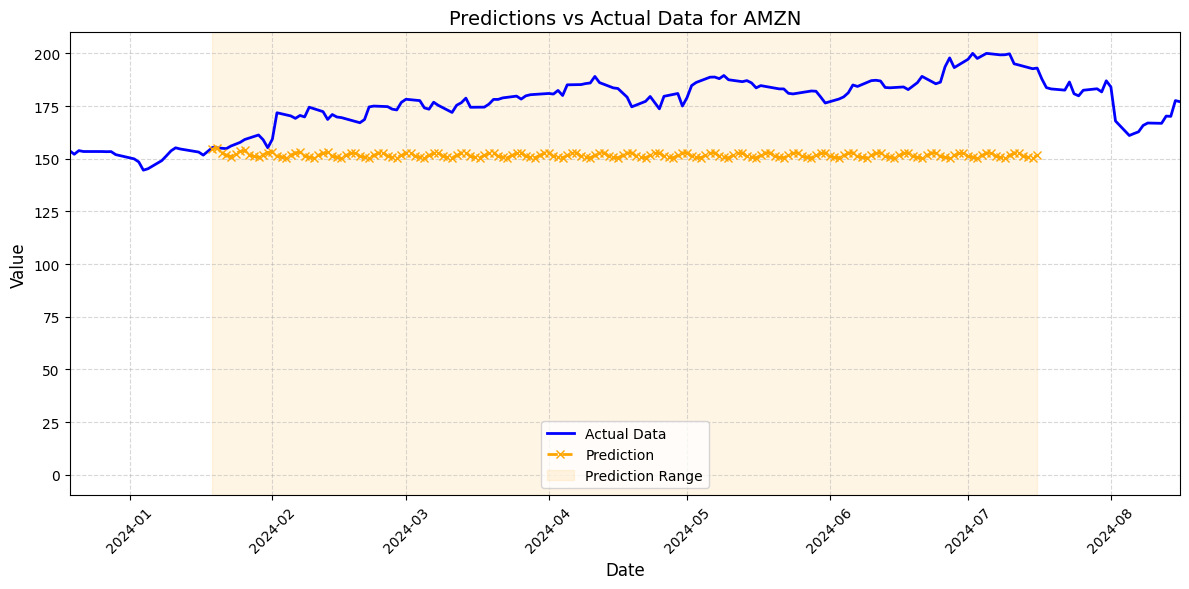


Graficando las predicciones para NVDA...


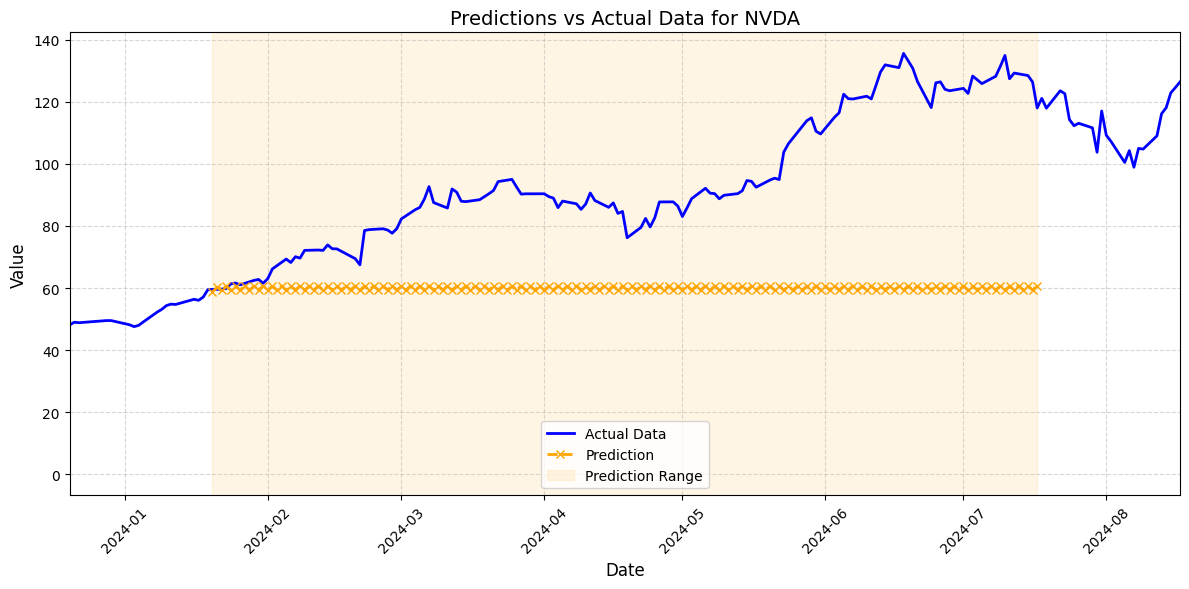


Graficando las predicciones para META...


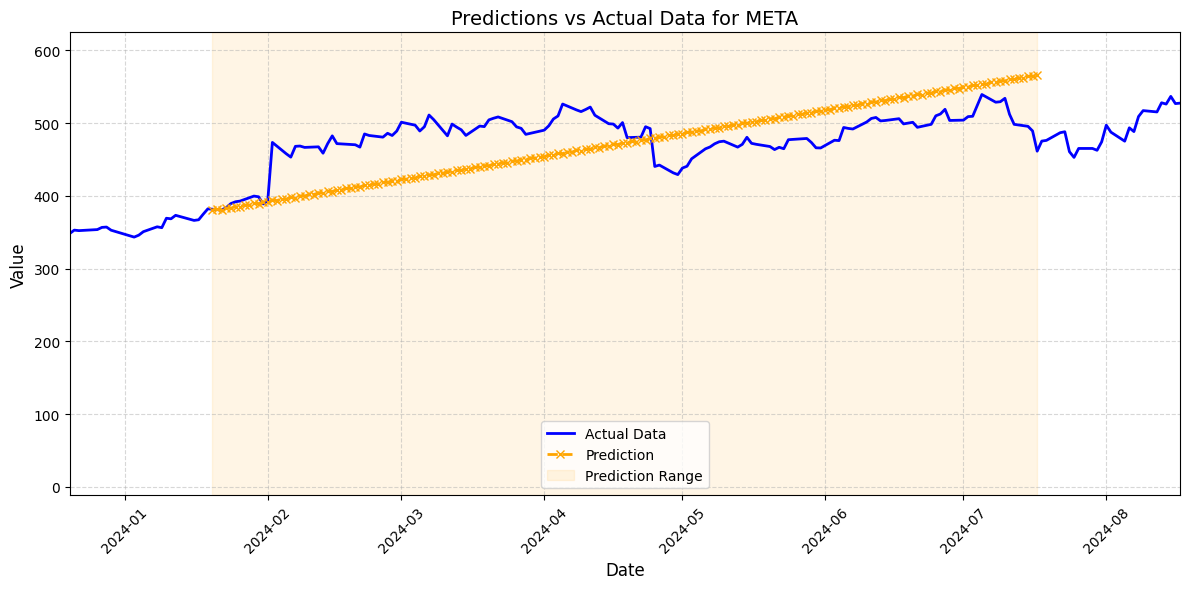


Graficando las predicciones para IBM...


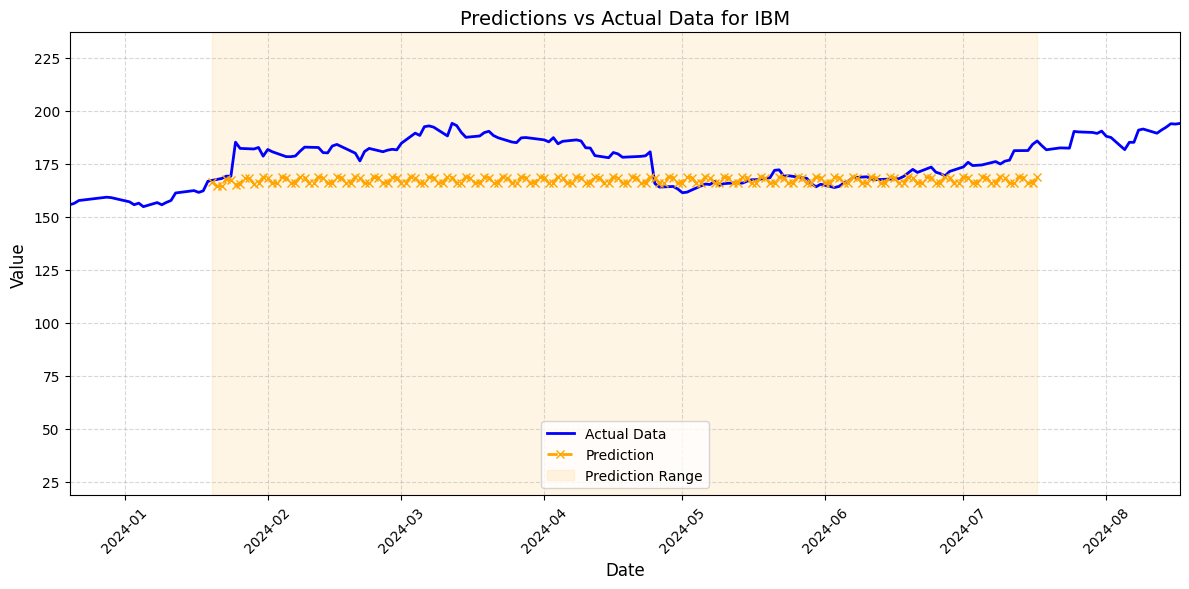


Graficando las predicciones para BTC-USD...


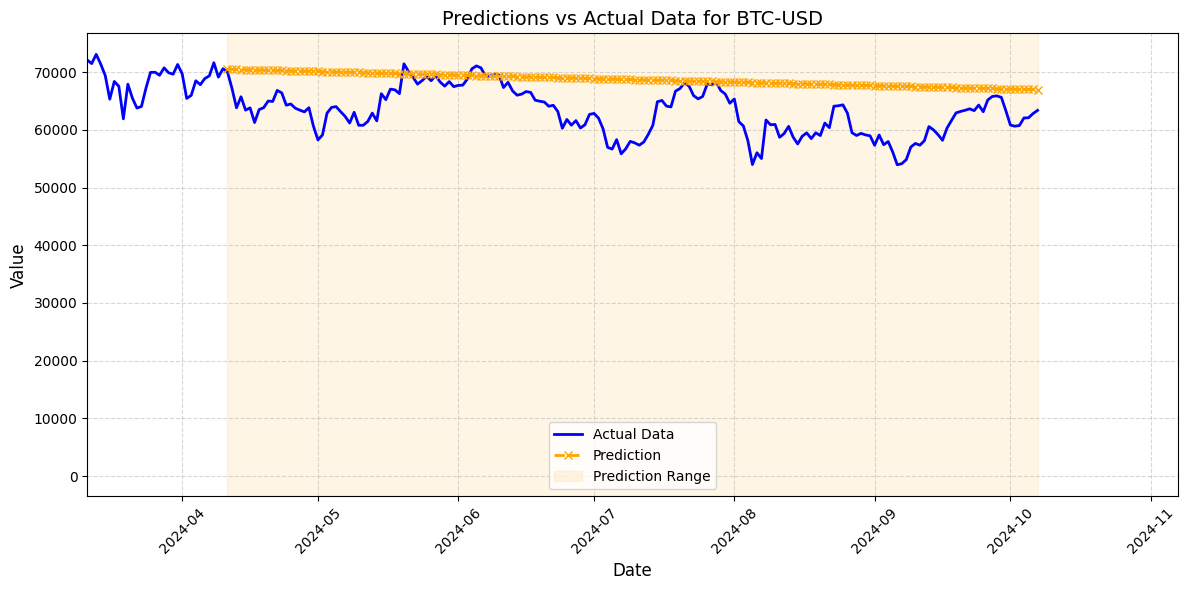

In [12]:
# Graficar resultados
for ticker in forecasts_dict:
    print(f"\nGraficando las predicciones para {ticker}...")
    plot_predictions(ticker, forecasts_dict[ticker])